**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) - **this notebook**
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences) 
* [Part 7: Survival analysis](https://www.kaggle.com/code/konradb/ts-7-survival-analysis)
* [Part 8: Hierarchical time series](https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series)
* [Part 9: Hybrid methods](https://www.kaggle.com/code/konradb/ts-9-hybrid-methods/)
* [Part 10: Validation methods for time series](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series/)
* [Part 11: Transfer learning](https://www.kaggle.com/code/konradb/ts-11-deep-learning-for-ts-transfer-learning)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E) 
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs) - **based on this notebook**
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk)
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo)
* [Talk 11]()


---------------------------------------


In the previous installments of this series, we discussed fundamental concepts from time series analysis, as well as vintage methods like exponential smoothing and the ARIMA family. In this one, we focus on the idea of a one stop shop for time series analysis: in the last few years, several packages have appeared that position themselves in such a fashion. We will take them for a test drive and have a look at how close they come to fulfilling the promise. Each of the packages implementing the "automatic for the people" philosophy for time series has it own dedicated section below:

* [AutoTS](#section-one)
* [Darts](#section-two)
* [Kats](#section-three)
* [Bonus track: GluonTS](#section-four) 

Disclaimer: since the packages we use are somewhat experimental (and as such, not part of the Kaggle Docker image), we will need to install each of them separately in their respective sections.

In [ ]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    #  for faster iteration / execution
    cutoff = '2018-01-01'        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [ ]:
# helper functions
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

For the sake of a meaningful comparison, we will stick to the same dataset across different models and revisit the Nifty-50 data we used in the ARIMA episode https://www.kaggle.com/code/konradb/ts-2-linear-vision.


In [ ]:
stock_name = 'TATASTEEL'

# load the data
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')



In [ ]:
# split into training / validation
df_train, df_test = df.iloc[df.index <= '2021-01-01'], df.iloc[df.index > '2021-01-01']
print(df_train.shape, df_test.shape)



<a id="section-one"></a>
# AutoTS


Auto-TS is the closest we have in applying the AutoML philosophy specifically to time series. Primary features include:

* finding an optimal time series forecasting model using genetic programming optimization
* training diverse models
* data transformations 
* combination of metrics for model selection

In [ ]:
!pip install autots

In [ ]:
from autots.models.model_list import model_lists
from autots import AutoTS

First thing we do: which models are available to play with? The possible candidate models are grouped into several (overlapping!) classes:

In [ ]:
model_lists.keys()

In [ ]:
# full list of models:
model_lists['all']

In [ ]:
model_lists['fast']

In [ ]:
model_lists['superfast']

In [ ]:
model_lists['probabilistic']

There are quite a few models to choose from (most of which weren't discussed before), but we focus on one: 
- the Theta method was proposed in 2000: https://www.researchgate.net/publication/223049702_The_theta_model_A_decomposition_approach_to_forecasting
- regression on time + exponential smoothing
- degrees of damping the trend via $\theta$
- de/reseasonalize


OLS: 

\begin{equation}
    X_t = a_0 + b_0 (t-1) + \epsilon_t 
\end{equation}


SES:
\begin{equation}
S_t = (1 - \alpha) X_t + \alpha S_{t-1}
\end{equation}


Forecast:
\begin{equation}
\hat{X}_{T+h|T} = \frac{\theta - 1}{\theta} b_0 \left[h - 1 + \frac{1}{\alpha} - \frac{(1 - \alpha)^T}{\alpha} \right] + S_{T+h | T}
\end{equation}


Specify the model parameters:

In [ ]:
# specify the model
model = AutoTS(
    forecast_length = len(df_test),
    frequency='infer',
    prediction_interval=0.9,
    ensemble=  'simple' , # select single best model
    # we want some results, but also execution in reasonable time
    # GA ARE SLOW
    model_list =  ['GLM', 'Theta', 'ETS'], 
    transformer_list="superfast",  
    drop_most_recent=1,
    max_generations=5,
    num_validations=2,
    validation_method = "backwards"
)


# fit the model
model = model.fit(
    df_train,
#     date_col= None, # 'datetime' if long else None,
#     value_col= None,#  'value' if long else None,
#     id_col= None,   #'series_id' if long else None,
)

In [ ]:
# generate prediction
prediction = model.predict()
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2019-01-01")

In [ ]:
# Print the details of the best model
print(model)

In [ ]:
# point forecasts 
forecasts_df = prediction.forecast

# upper and lower forecasts
forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast


In [ ]:
# quality of all tried model results
model_results = model.results()
model_results.head(3)

In [ ]:
# performance
my_rmse(forecasts_df, df_test.VWAP)

`AutoTS` summary:
* minimalistic setup - but tinkering possible
* cornucopia of (univariate) models
* GA is **slow**
* very much beta version

<a id="section-two"></a>
# Darts

An interesting example of a library combining multiple time series models is `darts` https://unit8co.github.io/darts/ . It takes a slightly different approach then AutoTS: instead of automatically combining a set of models from a predefined list, it allows us to setup evaluation of different models in standardized manner.

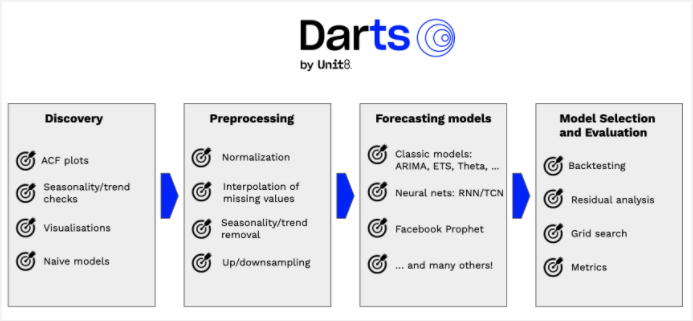

The list of possible candidate models is quite exhaustive:

* ARIMA
* Auto-ARIMA
* Baseline Models
* Block Recurrent Neural Networks
* Exponential Smoothing
* Fast Fourier Transform
* LightGBM Model
* Linear Regression model
* N-BEATS
* Facebook Prophet
* Random Forest
* Regression ensemble model
* Regression Model
* Recurrent Neural Networks
* Temporal Convolutional Network
* Temporal Fusion Transformer (TFT)
* Theta Method
* Transformer Model
* VARIMA

This package and `Kats` discussed in the next section have certain overlap in their focus, so in order to avoid redundancy we will take something of an *a la carte* approach.

In [ ]:
!pip install llvmlite --ignore-installed

In [ ]:
!pip install darts[all]

## Backtesting

In [ ]:
!python -m pip install prophet


In [ ]:
from darts import TimeSeries
from darts.models import Prophet, ExponentialSmoothing, AutoARIMA, Theta, RegressionEnsembleModel, RegressionModel

In this section we will focus on a very useful feature of `darts`: backtesting. A frequent approach to validation of time series models is to split the data on time: training set are all the observations up to some timepoint $t_0$ and validation is the part afterwards. While simple to set up, this approach runs the risk of overfitting to our chosen validation set. The `historical_forecast` method built into all the models in `darts` solves this problem by allowing us to perform a walk-forward validation:

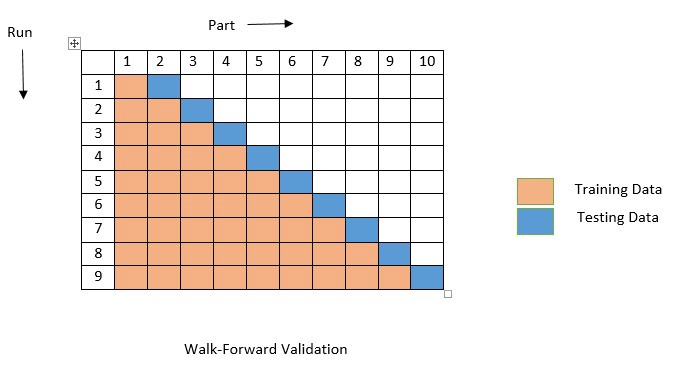

For the visually challenged people like me:
* we use an expanding training window
* for each run, we train the model on the training set and generate a forecast on test
* next run has an extended training set and a shifted test

Let's take some of the already familiar models, as well as a few new ones for a ride. First, we borrow a helpful wrapper function from the official documentation:

In [ ]:
from darts.metrics import rmse 

def eval_model(model, flow,
               past_covariates=None,  future_covariates=None,
              retrain = False,
              forecast_horizon = 10,
              last_obs = 200):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, 
    # with a horizon of `forecast_horizon` steps:
    backtest = model.historical_forecasts(series=flow, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon)
    
    flow[-len(backtest) - last_obs:].plot()
    backtest.plot(label='backtest (n=' + str(forecast_horizon) + ')')
    
    print('Backtest RMSE = {}'.format(np.round( rmse(flow, backtest) )))

Format the data into `darts` format:

In [ ]:
stock_names = 'TATAMOTORS'
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]
series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')
series.plot()
# df.set_index('Date').VWAP.plot()

We begin with exponential smoothing - for a refresher see https://www.kaggle.com/code/konradb/ts-1a-smoothing-methods

In [ ]:
# ExponentialSmoothing can't handle NAs :-(
from darts.utils.missing_values import fill_missing_values
series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

In [ ]:
model = ExponentialSmoothing()
eval_model(model, flow = train, 
           retrain = True,   forecast_horizon = 7)

In [ ]:
eval_model(model, flow = train, retrain = True, forecast_horizon = 15)

In [ ]:
eval_model(model, flow = train, retrain = True, forecast_horizon = 30)

Next: Prophet, which `darts` also wraps (see https://www.kaggle.com/code/konradb/ts-1b-prophet if you missed that episode ;-) Not surprisingly, the backstesting - even at default parameters - takes a little longer than before.

In [ ]:
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')

model = Prophet()
eval_model(model, flow = train, retrain = True, forecast_horizon = 7)

No overview of vintage methods would be complete without ARIMA https://www.kaggle.com/code/konradb/ts-2-linear-vision

In [ ]:
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')
series = fill_missing_values(series)

model = AutoARIMA()
eval_model(model, flow = train, retrain = True, forecast_horizon = 7)

An interesting feature of `darts` is that unlike some other packages, we can use deep learning models in exact same manner. The package can incorporate different DL architectures (RNN, LSTM, Transformers) as well as hybrid approaches (N-Beats). Since this is our first venture into the #DeepLearnEverything space, let's start with the basics and fit an RNN:
- the first DL architecture focus on sequential data
- memory (vs LSTM)
- will get a full episode of their own ;-) 

In [ ]:
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')
series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)


# scale
model = RNNModel(
    model="RNN",
    hidden_dim=20, dropout=0,  batch_size=16, n_epochs= 10, optimizer_kwargs={"lr": 1e-3},
    model_name="muh_RNN", log_tensorboard=True, random_state=42, training_length=20,    
    input_chunk_length=14,
    
    force_reset=True,
    save_checkpoints=True,
)

In [ ]:
# eval_model(model, flow = train_transformed, retrain = True, forecast_horizon = 7)
# sadly, workaround needed to due my failure to suppress
# pages and pages of warnings
backtest = model.historical_forecasts(series=train_transformed, 
                                          past_covariates= None,
                                          future_covariates=None,
                                          start=0.8,  retrain=True, verbose=True, 
                                          forecast_horizon=7)

In [ ]:
train_transformed[-len(backtest) - 200:].plot()
backtest.plot(label='backtest (n=7)')

print('Backtest RMSE = {}'.format(np.round( rmse(train_transformed, backtest) )))

Now that we have seen how to evaluate individual models, the next step is fairly natural:


## Ensembling

In [ ]:
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.datasets import AirPassengersDataset

In [ ]:
# prepare the data
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(df, 'Date', 'VWAP', freq = 'D')
series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [ ]:

from functools import reduce
from darts.models import NaiveSeasonal, NaiveDrift

# define the list of models we use 

models = [# NaiveSeasonal(6), 
          AutoARIMA(),
          # NaiveDrift(),
          Theta(),
          # ExponentialSmoothing(),
          Prophet()
         ]


# create the backtests for the individual models
model_predictions = [m.historical_forecasts(series, 
                                            # start of the backtesting period for the individual models
                                            start=pd.Timestamp('2020-01-01'), 
                                            forecast_horizon=12, 
                                            stride=12, 
                                            last_points_only=False,
                                            verbose=True)
                     for m in models]

model_predictions = [reduce((lambda a, b: a.append(b)), model_pred) for model_pred in model_predictions]


In [ ]:
model_predictions_stacked = model_predictions[0]
for model_prediction in model_predictions[1:]:
    model_predictions_stacked = model_predictions_stacked.stack(model_prediction)

With historical forecasts calculated through backtesting, we can move towards training an ensemble model combining our component series. 

In [ ]:
# setup our ensembling model
regr_model = RegressionModel(lags=None, lags_future_covariates=[0], 
                             # anything with .fit and .predict methods from sklearn will do here - LinearRegression by default
                             model= Ridge()
                            )

# adjust index on the target series
series_target = series.slice_intersect(model_predictions[0])


In [ ]:
# backtest for the RegressionModel 
ensemble_pred = regr_model.historical_forecasts(
    series=series_target, future_covariates=model_predictions_stacked, 
    # start of the calibration periods for the ensemble 
    start=pd.Timestamp('2020-06-01'), 
    forecast_horizon=3, verbose=True
)

Finally, let's see how good the regression performs, compared to the original forecasts:

In [ ]:
import darts.metrics as dme
def muh_rmse(x,y):
    return np.round(np.sqrt(dme.mse(x,y)) ,2)

fig, ax = plt.subplots(2,2,figsize=(CFG.img_dim1,CFG.img_dim2))
ax = ax.ravel()

for i, m in enumerate(models):
    series.plot(label='actual', ax=ax[i])
    model_predictions[i].plot(label=str(m), ax=ax[i])
    
    # intersect last part, to compare all the methods over the duration of the ensemble forecast
    model_pred = model_predictions[i].slice_intersect(ensemble_pred)
       
    # model_error = mape(series, model_pred)
    model_error = muh_rmse(series, model_pred)
    ax[i].set_title('\nRMSE: {:.2f}'.format(model_error))
    ax[i].legend()

series.plot(label='actual', ax=ax[3])
ensemble_pred.plot(label='Ensemble', ax=ax[3])
ax[3].set_title('\nRMSE, ensemble: {:.2f}'.format(muh_rmse(series, ensemble_pred)))
ax[3].legend()

print('\nRegression coefficients for the individual models:')
for i, m in enumerate(models):
    print('Learned coefficient for {}: {:.2f}'.format(m, regr_model.model.coef_[i]))
plt.tight_layout();

`Darts` takeaway:
* multiple models - statistics, DL, hybrid
* backstesting
* ensembling 
* **transfer learning**


<a id="section-three"></a>
# Kats

Facebook Research unit made its first appearance in this series thanks to Prophet, but it is far from their only contribution to time series - recently they released their own one-stop-shop in the form of `Kats`: https://facebookresearch.github.io/Kats/. The elevator pitch for `Kats` contains it with  generic analysis, forecasting, anomaly detection, multivariate analysis, and feature extraction/embedding. An interesting feature is that it incorporates both vintage methods like ARIMA and modern ones (based on LSTM). 


Kats implements an ensembling solution just like `darts` (choosing an implementation is a YMMV type of situation), but their take on backtesting has useful metrics info not available - at least not so easily - in darts.

In [ ]:
!pip install llvmlite --ignore-installed

In [ ]:
!pip install kats

In [ ]:
from kats.models.prophet import ProphetModel, ProphetParams
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
from kats.models.arima import ARIMAModel, ARIMAParams

from kats.utils.backtesters import BackTesterSimple


In [ ]:
# stock_name = 'AXISBANK'
# df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
# df = df.loc[df.Date > CFG.cutoff]
# NAs strike again :-( 

# df.set_index("Date").VWAP.plot()
df = pd.read_csv(CFG.data_folder + 'energy_daily.csv')
df['y'] = df['y'] / 10**4
df.set_index("ds").y.plot()


In [ ]:
# prepare into Kats format
from kats.consts import TimeSeriesData
df.columns = ["time", "value"]
df['time'] = pd.to_datetime(df['time'])
df_ts = TimeSeriesData(df, time_col_name="time")

In [ ]:
backtester_errors = {}

# specify the metrics we are interested in
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv

In [ ]:
air_passengers_df = pd.read_csv("air_passengers.csv")
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)


ARIMA model:

In [ ]:

params = ARIMAParams(p=2, d=1, q=1)

backtester_arima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data= df_ts,
    params=params,
    train_percentage=75,
    test_percentage=25, 
    model_class=ARIMAModel)

backtester_arima.run_backtest()

In [ ]:
# store the errors in the dictionary
backtester_errors['arima'] = {}
for error, value in backtester_arima.errors.items():
    backtester_errors['arima'][error] = value

Prophet:

In [ ]:
params_prophet = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

backtester_prophet = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=df_ts,
    params=params_prophet,
    train_percentage=75,
    test_percentage=25, 
    model_class=ProphetModel)

backtester_prophet.run_backtest()



In [ ]:
backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

Exponential smoothing:


In [ ]:
params_hw = HoltWintersParams(trend = 'additive') # additive mode gives worse results

backtester_hw = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=df_ts,
    params=params_hw,
    train_percentage=75,
    test_percentage=25, 
    model_class=HoltWintersModel)

backtester_hw.run_backtest()


In [ ]:
backtester_errors['hw'] = {}
for error, value in backtester_hw.errors.items():
    backtester_errors['hw'][error] = value

Combine the results:


In [ ]:
pd.DataFrame.from_dict(backtester_errors)

`Kats` takeaway:
* multiple models - statistics, DL, hybrid (but fewer than darts)
* backstesting - more metrics
* ensembling 
* global model!


Don't say goodbye to `darts` and `Kats` just yet - we will meet them in again, in the episode dedicated to meta learning and transfer learning for time series. 

<a id="section-four"></a>
# Bonus track: GluonTS

For some inexplicable reason, `GluonTS` escaped my attention when I was writing this episode - but if a rock band can release a new version of an album with extra material, so can I :-) GluonTS is a library for probabilistic time series modeling, focusing on deep learning; while there are numerous libraries utilizing DL (including some desribed above), it's the probabilistic part that makes Gluon truly stand out (well, and the fact they are one of a few environments left that keep the torch burning for `MXNet`). In this section, we will take Gluon for a test drive.

In [ ]:
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

`GluonTS` comes with several DL models - full list of references (including source papers) is available in the official documentation https://github.com/awslabs/gluon-ts:

- DeepAR
- DeepState
- DeepFactor
- Deep Renewal Processes
- GPForecaster
- MQ-CNN
- MQ-RNN
- N-BEATS
- Rotbaum
- Causal Convolutional Transformer
- Temporal Fusion Transformer
- Transformer
- WaveNet
- SimpleFeedForward
- DeepVAR
- GPVAR
- LSTNet
- DeepTPP
- RForecast
- Prophet
- NaiveSeasonal
- Naive2
- NPTS



We will demonstrate Gluon capabilities by using DeepAR: an algorithm developed by Amazon Research that builds probabilistic forecasts for multiple time series using LSTM architecture as a basis (see the RNN episode for a refresher on LSTM https://www.kaggle.com/code/konradb/ts-6-deep-learning-for-ts-rnn-and-friends). TL;DR summary of the Amazon twist is that encoder and decoder networks share the same architecture:

[source](https://towardsdatascience.com/prophet-vs-deepar-forecasting-food-demand-2fdebfb8d282)

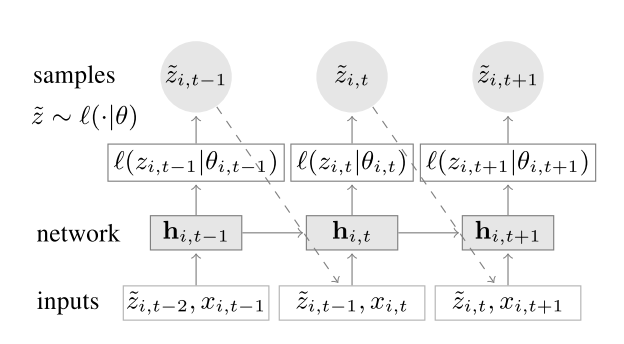

Main features of Deep AR:

- incorporation of covariates 

- a categorical variables specifying grouping of the related time series (models train an embedding vector that learns the common properties of all the time series in the group)

- automatic creation of additional feature time series, depending on the granularity of the target time series (e.g. indicators for day of week, month of year etc)

- MC sampling for distibutional properties inference 

- **Built-in item supersession**: It can predict on items with little history items by learning from similar items

We will use [dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption) on hourly energy consumption from across different regions in the US - due to regional variation, the patterns can differ substantially $\implies$ a single model handling them jointly has potential business value.


In [ ]:
# setup the data and align the lengths for simplicity

df1 = pd.read_csv("../input/hourly-energy-consumption/COMED_hourly.csv",parse_dates = True)
df1 = df1.loc[df1["Datetime"] > '2011-12-31'].reset_index(drop = True)
df2 = pd.read_csv("../input/hourly-energy-consumption/DOM_hourly.csv",parse_dates = True)
df2 = df2.loc[df2["Datetime"] > '2011-12-31'].reset_index(drop = True)
df3 = pd.read_csv("../input/hourly-energy-consumption/PJME_hourly.csv",parse_dates = True)
df3 = df3.loc[df3["Datetime"] > '2011-12-31'].reset_index(drop = True)


# (minor) DeepAR kink: convert everything long -> wide
def format_df(df):
    xname = df.columns[1][:-3]
    df = df.T
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df['Station_Name'] = xname
    df = df.reset_index(drop = True)

    return df


df1 = format_df(df1)
df2 = format_df(df2)
df3 = format_df(df3)


# combine
df_all = pd.concat([df1 , df2, df3] , axis = 0 )
df_all = df_all.set_index("Station_Name")
df_all = df_all.reset_index()


# grouping variable for using with DeepAR
ts_code=df_all['Station_Name'].astype('category').cat.codes.values
ts_code

In [ ]:
# train / test split
freq="1H"
start_train = pd.Timestamp("2011-12-31 01:00:00", freq=freq) 
start_test = pd.Timestamp("2016-06-10 18:00:00", freq=freq) 

prediction_lentgh= 24 * 1 

df_train=df_all.iloc[:,1:40000].values
df_test=df_all.iloc[:,40000:].values

Just like every other library discussed in this notebook, `GluonTS` has its own class for handling time series datasets:

In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_train,
                             ts_code.reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_test,
                            ts_code.reshape(-1,1))
], freq=freq)

After this (admittedly slightly longer than in previous cases ;-) preparation work, we can define our model - we give explanation for the DeepAR-specific parameters, as the rest is fairly standard for RNN / LSTM modeling:

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq=freq, 
                            context_length=24 * 5, 
                            prediction_length = prediction_lentgh,
                            # indicator variable to tell our model which time series observation is which
                            # see ts_code above                                                                
                            use_feat_static_cat=True,
                            # While making predictions we are only using the returns observation for each item month wise and no other extra features , 
                            # hence cardinality of 1
                            cardinality=[1],
                            num_layers=2,
                            num_cells=32,
                            cell_type='lstm',
                            dropout_rate = 0.25,
                            trainer=Trainer(epochs= 10 , learning_rate=1e-3  ,batch_size = 512, patience = 5 ))

Training the model is not a challenge to anybody familiar with the `scikit-learn` way of doing things:

In [ ]:
predictor = estimator.train(training_data=train_ds)


Generating predictions works in a manner slightly similar to Prophet: we need to generate MC samples to get at confidence intervals

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    num_samples=100, 
)


from tqdm.autonotebook import tqdm

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(df_test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(df_test)))

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [ ]:
for i in tqdm(range(3)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))

In [ ]:
agg_metrics

In [ ]:
item_metrics